# 2024-2 언어데이터과학 10강 (2024-10-15) `wordcloud` 패키지와 단어구름 그림

## 0. 준비

### 한글 폰트 설치하기 (for Github codespace)

+ 사용할 폰트: Noto Sans CJK

In [4]:
!mkdir -p ../fonts
!curl https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip > ../fonts/NotoSansCJKkr-hinted.zip
!unzip ../fonts/NotoSansCJKkr-hinted.zip -d ../fonts
!rm ../fonts/NotoSansCJKkr-hinted.zip

from matplotlib.font_manager import fontManager, FontProperties

font_path = "../fonts/NotoSansCJKkr-Regular.otf"
fontManager.addfont(font_path)

prop = FontProperties(fname=font_path)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  115M  100  115M    0     0  17.1M      0  0:00:06  0:00:06 --:--:-- 21.7M
Archive:  ../fonts/NotoSansCJKkr-hinted.zip
replace ../fonts/LICENSE_OFL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### 파이썬 모듈 설치하기

In [2]:
%pip install -U pip konlpy tqdm wordcloud

Note: you may need to restart the kernel to use updated packages.


### 코퍼스 파일 다운로드하기

In [5]:
!mkdir -p ../data/nsmc
!curl https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt > ../data/nsmc/ratings.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.6M  100 18.6M    0     0   145M      0 --:--:-- --:--:-- --:--:--  145M


In [6]:
!head ../data/nsmc/ratings.txt

id	document	label
8112052	어릴때보고 지금다시봐도 재밌어요ㅋㅋ	1
8132799	디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다.	1
4655635	폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.	1
9251303	와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런게 진짜 영화지	1
10067386	안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.	1
2190435	사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화	1
9279041	완전 감동입니다 다시봐도 감동	1
7865729	개들의 전쟁2 나오나요? 나오면 1빠로 보고 싶음	1
7477618	굿	1


## 1. 데이터 전처리

### 데이터프레임으로 읽기

In [7]:
import pandas as pd

df = pd.read_csv('../data/nsmc/ratings.txt', sep='\t')
df

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...,...
199995,8963373,포켓 몬스터 짜가 ㅡㅡ;;,0
199996,3302770,쓰.레.기,0
199997,5458175,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


### 자료형 확인하기

영화평은 텍스트로 이루어져 있으므로 Python에서 자료형이 문자열(`str`)이라고 예측할 수 있다.

그러나 `pandas`에서 내용을 자동으로 읽었기 때문에, 문자열이 아닌 다른 자료형으로 처리되었을 수도 있다.

영화평(`df['document']`)의 자료형을 `type()` 함수로 확인해 보자.

In [8]:
df['document'].apply(type).value_counts()

document
<class 'str'>      199992
<class 'float'>         8
Name: count, dtype: int64

위와 같이 200000개 중 8개가 `str`이 아닌 `float`인 것을 알 수 있다.

이 문제를 해결하기 위해서는 `Series.astype()` 메소드로 자료형을 지정해 주어야 한다.

In [10]:
df['document'] = df['document'].astype(str)

## 2. 키워드 추출

여기에서는 영화평의 키워드를 보고자 하므로, 모든 품사를 다 사용하기보다는 명사만 사용하는 것이 효율적이다.

`konlpy.tag`의 형태소 분석기에서는 `Okt.nouns()`와 같이 명사만 골라서 추출할 수 있다.

In [11]:
from konlpy.tag import Okt

tagger = Okt()

text = df['document'][135]
print(text) # 원문
print(tagger.nouns(text)) # 명사 추출

어릴 땐 온 가족이서 봤던 영화. 처음으로 집 마련하고 이사마치고 그날 저녁에 본 영화. 그 때의 기분 탓인진 몰랐는지만 그렇게 웃길 수가 없었다.
['땐', '온', '가족', '이서', '영화', '처음', '집', '마련', '사마', '그날', '저녁', '영화', '그', '때', '기분', '탓', '진', '수가']


이제 모든 영화평 각각에서 명사를 추출해 보자.

`tqdm.pandas()`를 설정한 뒤, `Series.apply()` 대신 `Series.progress_apply()`를 사용하면 진행 상황을 눈으로 볼 수 있다.

In [12]:
from tqdm import tqdm # 반복 진행 상태를 막대로 보여준다.
tqdm.pandas()

df['nouns'] = df['document'].progress_apply(tagger.nouns)

  0%|          | 0/200000 [00:00<?, ?it/s]

100%|██████████| 200000/200000 [05:47<00:00, 575.30it/s]


In [20]:
from collections import Counter

df['counts'] = df['nouns'].progress_apply(Counter)
df

100%|██████████| 200000/200000 [00:00<00:00, 285133.13it/s]


,id,document,label,nouns,counts
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,"[때, 보고, 지금, 다시]","{'때': 1, '보고': 1, '지금': 1, '다시': 1}"
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1,"[디자인, 학생, 외국, 디자이너, 그, 일군, 전통, 통해, 발전, 문화, 산업,...","{'디자인': 1, '학생': 1, '외국': 1, '디자이너': 1, '그': 2..."
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1,"[폴리스스토리, 시리즈, 부터, 뉴, 하나, 최고]","{'폴리스스토리': 1, '시리즈': 1, '부터': 1, '뉴': 1, '하나':..."
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1,"[연기, 진짜, 개, 생각, 몰입, 진짜, 영화]","{'연기': 1, '진짜': 2, '개': 1, '생각': 1, '몰입': 1, '..."
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1,"[안개, 밤하늘, 초승달, 영화]","{'안개': 1, '밤하늘': 1, '초승달': 1, '영화': 1}"
...,...,...,...,...,...
199995,8963373,포켓 몬스터 짜가 ㅡㅡ;;,0,"[포켓, 몬스터]","{'포켓': 1, '몬스터': 1}"
199996,3302770,쓰.레.기,0,"[레, 기]","{'레': 1, '기': 1}"
199997,5458175,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0,"[완전, 사이코, 영화, 마지막, 더욱더, 이, 영화, 질, 트, 린다]","{'완전': 1, '사이코': 1, '영화': 2, '마지막': 1, '더욱더': ..."
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0,"[왜, 라따뚜이, 스머프, 런가]","{'왜': 1, '라따뚜이': 1, '스머프': 1, '런가': 1}"


In [21]:
# 카운터는 서로 더할 수 있다.
counter1 = Counter({'a': 1, 'b': 2})
counter2 = Counter({'b': 1, 'c': 1})
print(counter1 + counter2)

Counter({'b': 3, 'a': 1, 'c': 1})


In [22]:
labels = df['label'].unique() # 1: 긍정적, 0: 부정적
labels

array([1, 0])

In [23]:
counts = {label: Counter() for label in labels}
counts

{np.int64(1): Counter(), np.int64(0): Counter()}

In [24]:
df.shape[0] # df의 행의 개수

200000

In [25]:
# 코드는 간결하지만 메모리 소모가 큼
# counts = df.groupby('label')['counts'].sum()

In [26]:
# df 전체의 각 행에 대한 반복문
for (i, row) in tqdm(df.iterrows(), total=df.shape[0]):
  label = row['label'] # 0 또는 1
  counter = row['counts']
  counts[label] += counter

100%|██████████| 200000/200000 [02:26<00:00, 1361.50it/s]


In [27]:
import pickle
with open('../data/nsmc-counters.pkl', 'wb') as f:
    pickle.dump(counts, f)

In [28]:
# counts[0] # Counter
print(counts[0].most_common(10))

[('영화', 32943), ('점', 6175), ('진짜', 5819), ('이', 5551), ('평점', 4936), ('스토리', 4548), ('왜', 4458), ('쓰레기', 4380), ('정말', 4366), ('것', 4251)]


In [29]:
print(counts[1].most_common(10))

[('영화', 35096), ('정말', 8477), ('최고', 7448), ('진짜', 5460), ('이', 5181), ('감동', 5154), ('연기', 4937), ('생각', 4491), ('점', 4401), ('것', 4205)]


## 3. 단어구름 그리기

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

palettes = ['spring', 'summer']
font_path = '../fonts/NotoSansCJKkr-Regular.otf'

def plot(counts):
  for label in counts.keys():
    plt.subplot(1, len(counts), label+1) # 작은 그림: (1, 2) 모양의 그림
    wc = WordCloud(font_path=font_path, width=600, height=600, colormap=palettes[label])
    gen = wc.generate_from_frequencies(counts[label]) # 인자: Counter
    plt.axis('off')
    plt.imshow(gen) # 작은 그림
  
  plt.show() # 큰 그림 출력

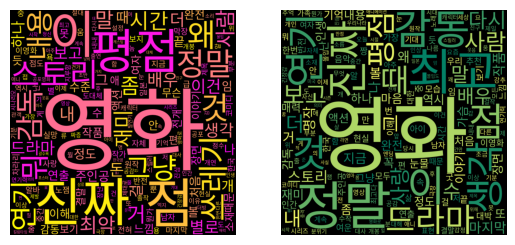

In [39]:
plot(counts)

## 4. 키워드 목록 수정하기

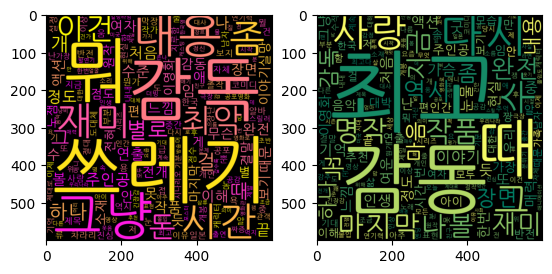

In [23]:
# from copy import deepcopy
# counts_exclusive = deepcopy(counts)
# # DO SOMETHING HERE
# # DO SOMETHING HERE
# # DO SOMETHING HERE

# plot(counts_exclusive)